# Experiments 

In [1]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from visualization import *
from utils import *

In [61]:
# load ground truth data
ground_truth = pd.read_csv('./../data/cleaned_all_data.csv')
objects = list(ground_truth['prompt'].value_counts().head(4).index)
print(f"Top {len(objects)} of objects in the dataset: {objects}")
# filter out lines about other objects than those 4
ground_truth = ground_truth[ground_truth['prompt'].isin(objects)]
# check type is only 'uses
print(ground_truth['type'].value_counts())

ocsai_eval_merged_gpt35_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_30.csv')
ocsai_eval_merged_gpt4_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_30.csv')

Top 4 of objects in the dataset: ['brick', 'box', 'knife', 'rope']
type
uses    10985
Name: count, dtype: int64


In [62]:
ground_truth = ground_truth[['prompt', 'response', 'target']]
ground_truth.rename(columns = {"target": "originality"}, inplace=True)
ground_truth['elaboration'] = ground_truth['response'].apply(lambda x: len(x.split()))
ground_truth.head()

,prompt,response,originality,elaboration
3,rope,use it to tie up a bicycle,1.9,7
4,rope,steps,1.3,1
5,rope,dog toy,1.4,2
6,box,use it to reach something,1.7,5
7,brick,strength tester (punching),2.7,3



## Experiment 1

Test if creativity higher when we output 100 ideas at once or 4 times 25 ideas (closer to human behavior)

In [3]:
object = objects[3] # select the object
print(f"Selected object: {object}")

Selected object: rope


In [4]:
# Generate the 100 responses for the selected object
df = pipeline_object(object, 100)

for i in tqdm(range(len(df))):
    eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])
    df.loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
    df.loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']

# check if there are any NaNs
if df.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df.to_csv(f'./data_ocsai/data_exp1/aut_{object}_100_test.csv', index=False) 
    print("Saved successfully")

df.head()

System fingerprint: fp_b28b39ffa8
Prompt tokens: 199
Completion tokens: 1461
Total number of tokens: 1660
Estimated price: $0.04582


100%|██████████| 96/96 [02:16<00:00,  1.42s/it]

Saved successfully


,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,Use it as a makeshift clothesline for drying l...,1.3,9.0
1,rope,Create a DIY pet leash for small animals like ...,1.7,13.0
2,rope,Fashion it into a decorative macrame plant han...,2.0,11.0
3,rope,Use it as a belt in emergencies for a quick fix.,1.3,11.0
4,rope,Construct a rope ladder for accessing loft spa...,1.3,10.0


In [17]:
# Generate 4 times 25 responses for the selected object
dfs = {}

for N in range(4):
    print(f"Started generation round {N+1}...")
    dfs[N] = pipeline_object(object, 25)
    
    for i in tqdm(range(len(dfs[N]))):
        eval_ocsai = call_api_ocsai(dfs[N].loc[i, 'prompt'], dfs[N].loc[i, 'response'])
        dfs[N].loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
        dfs[N].loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']

# merge the 4 dataframes
df_merged = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3]], ignore_index=True)
df_merged.head()

Started generation round 1...


System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 350
Estimated price: $0.012490000000000001


100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


Started generation round 2...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 405
Estimated price: $0.014140000000000002


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Started generation round 3...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 409
Estimated price: $0.01426


100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Started generation round 4...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 443
Estimated price: $0.01528


100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,Create a hanging shelf for plants or books.,3.3,8.0
1,rope,Braid a thicker rope for a durable dog leash.,1.7,9.0
2,rope,Weave a basket or container for storing items.,2.0,8.0
3,rope,Craft a rustic picture frame.,2.7,5.0
4,rope,Make a swing for children or a hammock for rel...,1.3,11.0


In [18]:
# check if there are any NaNs
if df_merged.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df_merged.to_csv(f'./data_ocsai/data_exp1/aut_{object}_4x25.csv', index=False) 
    print("Saved successfully")

Saved successfully


## Analysis of the results

In [14]:
def load_data_exp1(model):
    """
    Load the data for the first experiment
    """
    # load data with 100 responses
    aut_box_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_box_100.csv')
    aut_brick_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_brick_100.csv')
    aut_knife_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_knife_100.csv')
    aut_rope_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_rope_100.csv')

    # load data with 4x25 responses
    aut_box_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_box_4x25.csv')
    aut_brick_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_brick_4x25.csv')
    aut_knife_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_knife_4x25.csv')
    aut_rope_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_rope_4x25.csv')

    # merge the dataframes
    ocsai_eval_merged_gpt35_100 = pd.concat([aut_box_100, aut_brick_100, aut_knife_100, aut_rope_100])
    ocsai_eval_merged_gpt35_4x25 = pd.concat([aut_box_4x25, aut_brick_4x25, aut_knife_4x25, aut_rope_4x25])
    #rename the columns originality
    ocsai_eval_merged_100 = ocsai_eval_merged_gpt35_100.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
    ocsai_eval_merged_4x25 = ocsai_eval_merged_gpt35_4x25.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
    
    return ocsai_eval_merged_100, ocsai_eval_merged_4x25

ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25 = load_data_exp1('gpt_35')
ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25 = load_data_exp1('gpt_4')

# load data from mistral
ocsai_eval_merged_mistral_30 = pd.read_csv('./data_ocsai/mistral/ocsai_eval_merged_mistral_30.csv')

display(ocsai_eval_merged_gpt35_100.head(2), ocsai_eval_merged_gpt35_4x25.head(2), ocsai_eval_merged_gpt4_100.head(2), ocsai_eval_merged_gpt4_4x25.head(2))

,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0


,prompt,response,originality,elaboration
0,box,Use it as a mini herb garden by planting herbs...,3.0,11.0
1,box,Convert it into a unique wall shelf by adding ...,2.0,12.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0
1,box,Use it as a makeshift sled on snowy days.,2.0,9.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini greenhouse for starti...,3.0,9.0
1,box,Cut out shapes and use it as a stencil for art...,3.0,12.0


In [4]:
# save merged dataframes with 100 examples
#ocsai_eval_merged_gpt35_100.to_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_100.csv', index=False)
#ocsai_eval_merged_gpt4_100.to_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_100.csv', index=False)

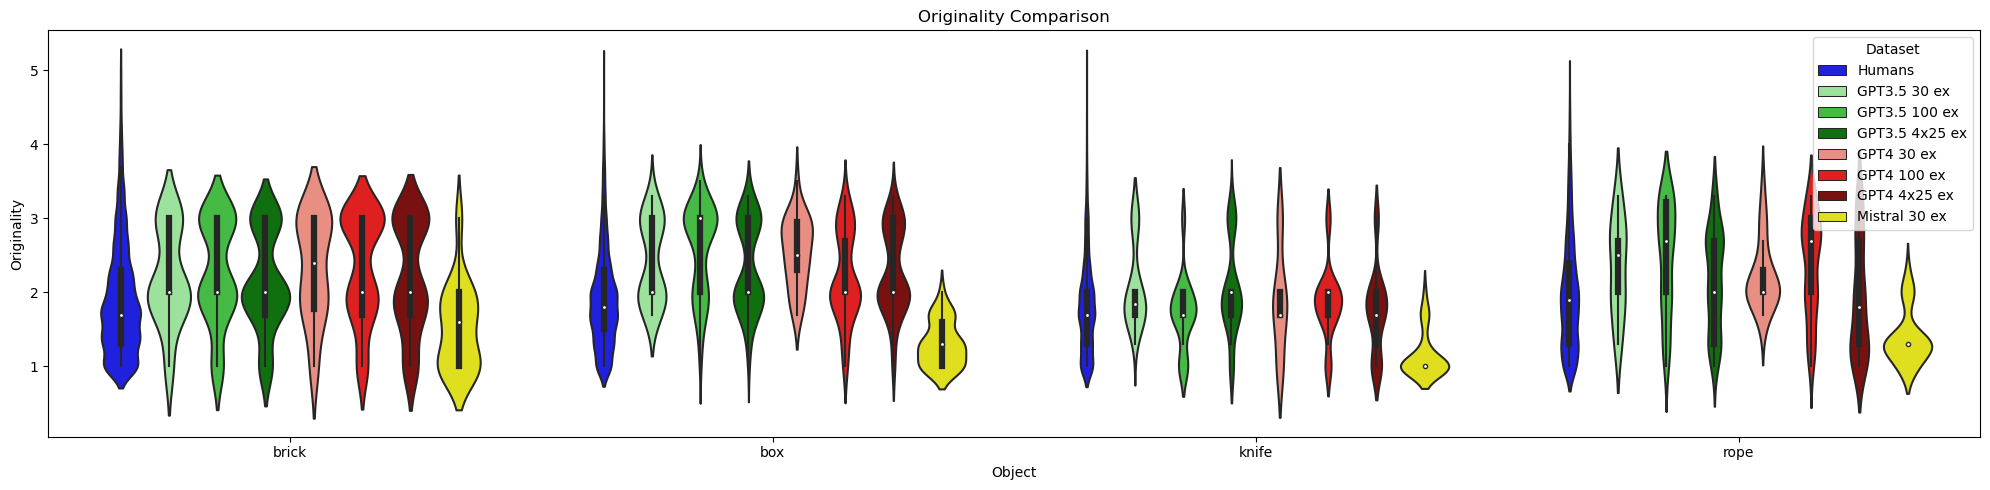

In [33]:
ground_truth_test = ground_truth.rename(columns={"target": "originality"})

combined_data = pd.concat([
    ground_truth_test.assign(dataset='Humans'),
    ocsai_eval_merged_gpt35_30.assign(dataset='GPT3.5 30 ex'),
    ocsai_eval_merged_gpt35_100.assign(dataset='GPT3.5 100 ex'),
    ocsai_eval_merged_gpt35_4x25.assign(dataset='GPT3.5 4x25 ex'),
    ocsai_eval_merged_gpt4_30.assign(dataset='GPT4 30 ex'),
    ocsai_eval_merged_gpt4_100.assign(dataset='GPT4 100 ex'),
    ocsai_eval_merged_gpt4_4x25.assign(dataset='GPT4 4x25 ex'),
    ocsai_eval_merged_mistral_30.assign(dataset='Mistral 30 ex')
])
# Set up the figure and axes
plt.figure(figsize=(20, 5))


# Define a custom color palette
colors = {'Humans': 'blue', 'GPT3.5 30 ex': 'lightgreen', 'GPT3.5 100 ex': 'limegreen', 'GPT3.5 4x25 ex': 'green',
          'GPT4 30 ex': 'salmon', 'GPT4 100 ex': 'red', 'GPT4 4x25 ex': 'darkred', 'Mistral 30 ex': 'yellow'}

# Plot violin plots
sns.violinplot(x='prompt', y='originality', hue='dataset', data=combined_data[combined_data['prompt'].isin(objects)],
               order=objects, palette=colors.values())  # Use custom color palette

#sns.catplot(data=df, x="age", y="class", hue="sex", kind="violin")

plt.title('Originality Comparison')
plt.xlabel('Object')
plt.ylabel('Originality')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

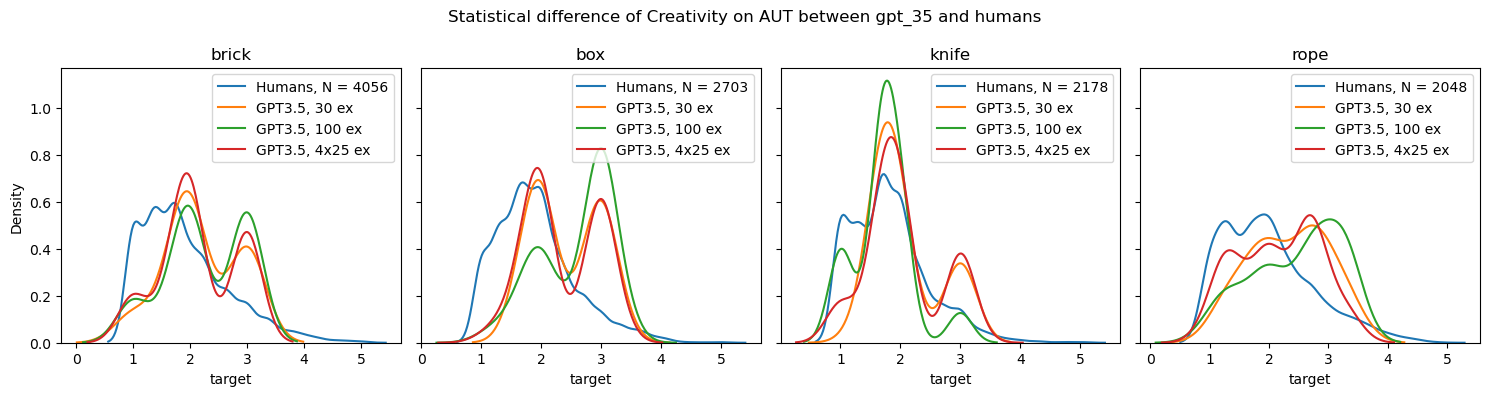

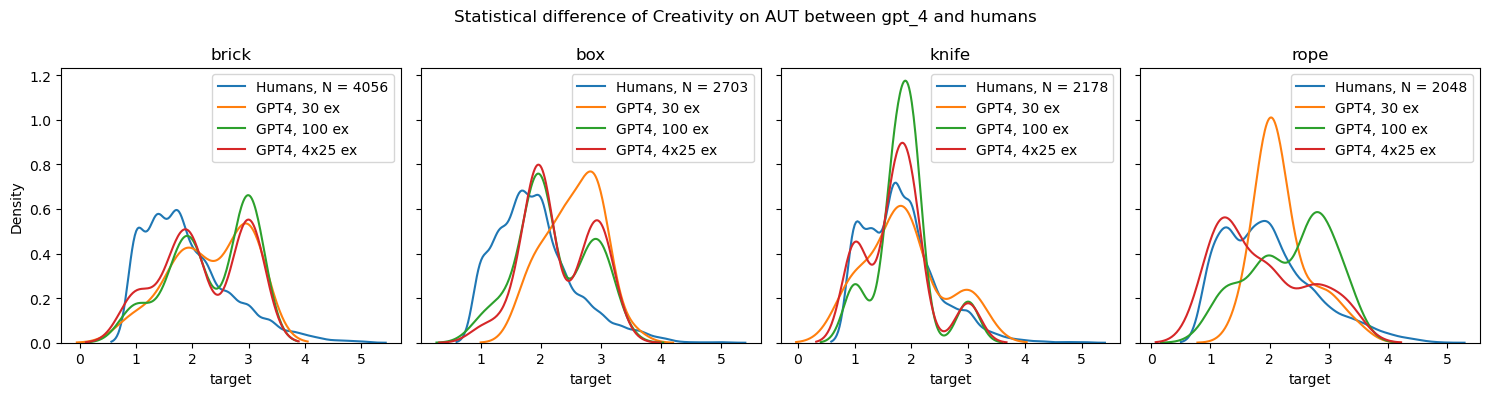

In [34]:
plot_kde_exp1('gpt_35', ocsai_eval_merged_gpt35_30, ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25, ocsai_eval_merged_gpt4_30, ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25)
plot_kde_exp1('gpt_4', ocsai_eval_merged_gpt35_30, ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25, ocsai_eval_merged_gpt4_30, ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25)

NOTE: Overall, generating 100 samples seem to be better than all the rest. Let's compare the 2 models now.

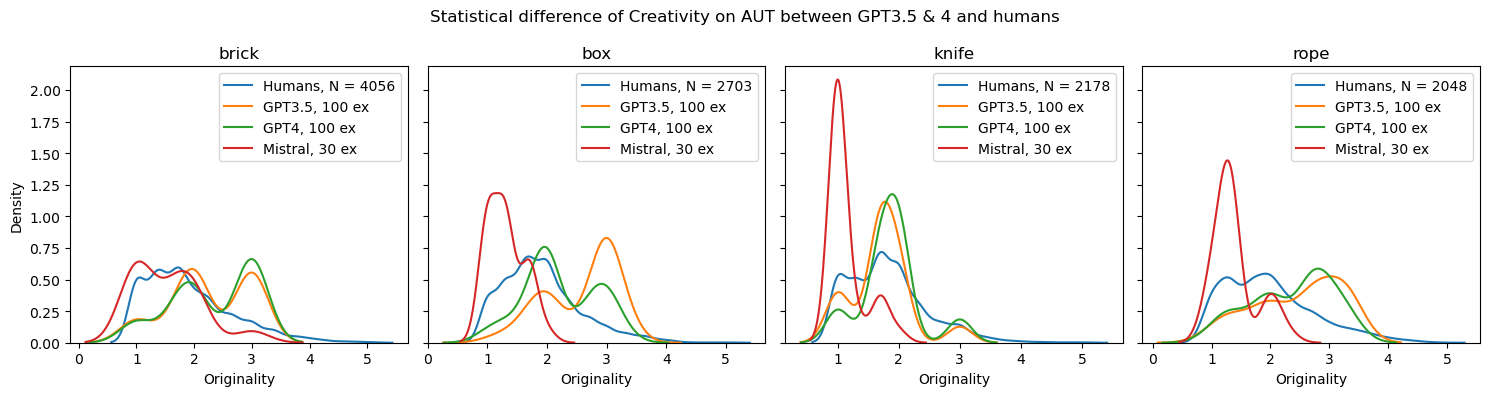

In [35]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)
for i, object_name in enumerate(objects):
    # normalize the values in ground truth and ocsai_eval_merged
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    object_ocsai_eval_mistral_30 = ocsai_eval_merged_mistral_30[ocsai_eval_merged_mistral_30['prompt'] == object_name]
    
    sns.kdeplot(object_ground_truth['target'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.kdeplot(object_ocsai_eval_gpt35_100['originality'], label=f'GPT3.5, 100 ex', ax = axs[i])
    sns.kdeplot(object_ocsai_eval_gpt4_100['originality'], label=f'GPT4, 100 ex', ax = axs[i])
    sns.kdeplot(object_ocsai_eval_mistral_30['originality'], label=f'Mistral, 30 ex', ax = axs[i])
    
    axs[i].set_title(f'{object_name}')
    axs[i].set_xlabel('Originality')
    axs[i].legend()
plt.suptitle(f'Statistical difference of Creativity on AUT between GPT3.5 & 4 and humans')
plt.tight_layout()
plt.show()

NOTE: GPT3.5 seems to be slightly better.

Analysis of statistical significance

**Hypothesis tests:** More info [here](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1b-statistical-methods/parametric-nonparametric-tests) to choose the right test.

In [39]:
# Normality test for the 3 distributions: ground_truth, gpt3.5 and gpt4
from scipy.stats import shapiro

# normality test
stat_humans, p_humans = shapiro(ground_truth['target'])
stat_gpt35, p_gpt35 = shapiro(ocsai_eval_merged_gpt35_100['originality'])
stat_gpt4, p_gpt4 = shapiro(ocsai_eval_merged_gpt4_100['originality'])
print('Humans: Statistics=%.3f, p=%.3f' % (stat_humans, p_humans))
print('GPT3.5: Statistics=%.3f, p=%.3f' % (stat_gpt35, p_gpt35))
print('GPT4: Statistics=%.3f, p=%.3f' % (stat_gpt4, p_gpt4))

# all p values are < 0.05 --> we reject the null hypothesis that those distributions come from a normal distribution.
# with TCL, we can suppose that the distribution are normally distributed

Humans: Statistics=0.893, p=0.000
GPT3.5: Statistics=0.904, p=0.000
GPT4: Statistics=0.904, p=0.000


c:\Users\Maxime\anaconda3\envs\ada\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [46]:
# t test between GPT3.5 and GPT4
from scipy.stats import ttest_ind, kruskal

print("T test, with TCL approximation (>30 samples)")
for object_name in objects:
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    
    
    t_stat, p_val = ttest_ind(object_ocsai_eval_gpt35_100['originality'], object_ocsai_eval_gpt4_100['originality'])
    print(f"Object: {object_name} - t-statistic: {t_stat}, p-value: {p_val}")
    
print("\nKruskal-Wallis, for quantitative non-normal outcome and categorical input")
for object in objects:
    object_ground_truth = ground_truth[ground_truth['prompt'] == object]
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object]
    
    stat, p = kruskal(object_ground_truth['target'], object_ocsai_eval_gpt35_100['originality'], object_ocsai_eval_gpt4_100['originality'])
    print(f"Object: {object} - Statistics: {stat}, p-value: {p}")


T test, with TCL approximation (>30 samples)
Object: brick - t-statistic: -0.6469538107025932, p-value: 0.5185447889011026
Object: box - t-statistic: 4.028228703529816, p-value: 8.36533876666629e-05
Object: knife - t-statistic: -1.8285904129863644, p-value: 0.06928881813066225
Object: rope - t-statistic: 0.9379356491440299, p-value: 0.34961597387237175

Kruskal-Wallis, for quantitative non-normal outcome and categorical input
Object: brick - Statistics: 52.14020035034378, p-value: 4.7632058562497864e-12
Object: box - Statistics: 99.48364949369383, p-value: 2.4968933497256137e-22
Object: knife - Statistics: 3.3027306151744495, p-value: 0.19178788033869226
Object: rope - Statistics: 57.670215627240914, p-value: 2.999658339358886e-13


According to Kruskal-Wallis test, we can reject the hypothesis that gpt3.5 and gpt4 have the same median for all objects except knife.

#### Issue check: problem of length = some runs of 100 did not have 100 responses

Hypothesis: the context window has been overcome

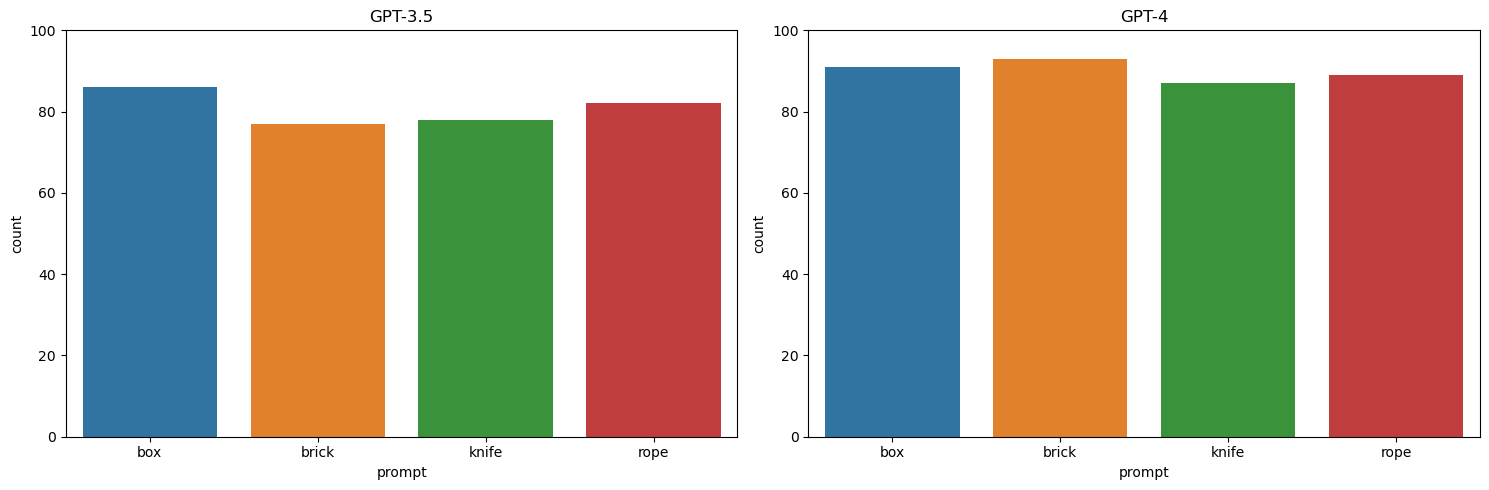

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=ocsai_eval_merged_gpt35_100, x='prompt', ax=axs[0])
axs[0].set_title('GPT-3.5')
axs[0].set_ylim(0, 100)
sns.countplot(data=ocsai_eval_merged_gpt4_100, x='prompt', ax=axs[1])
axs[1].set_title('GPT-4')
axs[1].set_ylim(0, 100)
plt.tight_layout()
plt.show()

In [23]:
prompt_test = create_prompt('rope', 100)

test_df = pd.read_csv('./data_ocsai/data_exp1/gpt_4/aut_rope_100_test_context_window.csv')

N_prompt_tokens = len(prompt_test.split())
N_output_tokens_35 = test_df['response'].apply(lambda x: len(x.split())).sum()
N_output_tokens_4 = ocsai_eval_merged_gpt4_100['response'].apply(lambda x: len(x.split())).sum()
#print(f"Number of tokens in the prompt: {N_prompt_tokens}")
#print(f"Number of tokens in the output for GPT-3.5: {N_output_tokens_35}")
#print(f"Number of tokens in the output for GPT-4: {N_output_tokens_4}")

# total number of tokens for gpt3.5 and gpt4
print(f"Total number of tokens for GPT-3.5: {N_prompt_tokens + N_output_tokens_35}")
print(f"Total number of tokens for GPT-4: {N_prompt_tokens + N_output_tokens_4}")

Total number of tokens for GPT-3.5: 3533
Total number of tokens for GPT-4: 3242


### U-shape analysis with Time series

**Hypothesis:** The U-shape of the outputs could be a sign of a creativity decline of the LLM. Contrary to humans, who use to generate more and more creative ideas when asked to be creative, LLMs first generate very creative ideas and then more common ideas.

**Test:** We will plot the creativity in time of the 100 runs and see if we recover the U-shape.

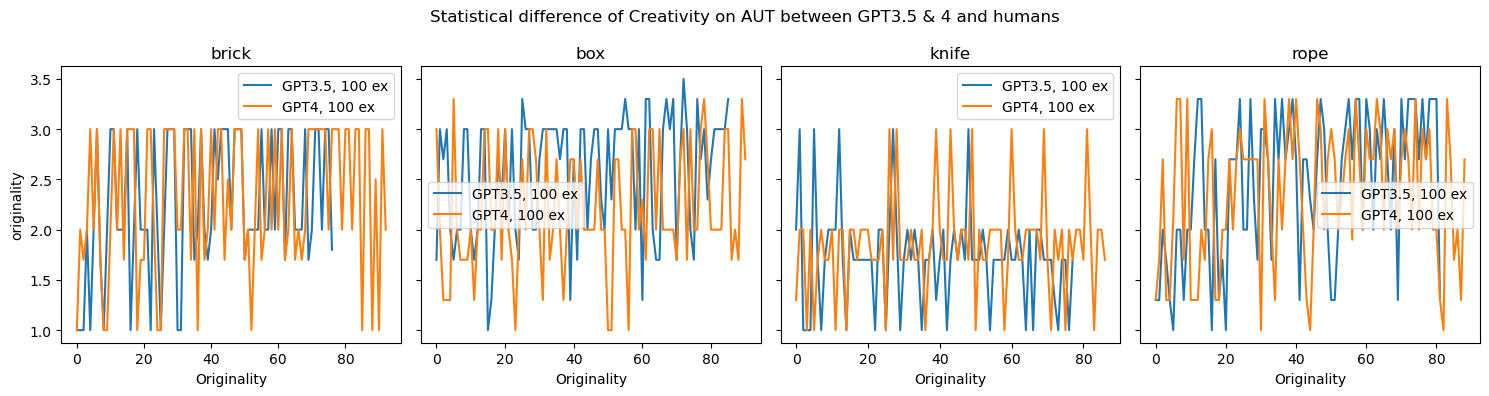

In [14]:
# create 4 subplots for each object
# one each subplot, plot a lineplot of the originality for both gpt_35 and gpt_4

fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)
for i, object_name in enumerate(objects):
    # normalize the values in ground truth and ocsai_eval_merged
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    object_ocsai_eval_mistral_30 = ocsai_eval_merged_mistral_30[ocsai_eval_merged_mistral_30['prompt'] == object_name]
    
    #sns.lineplot(object_ground_truth['target'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.lineplot(object_ocsai_eval_gpt35_100['originality'], label=f'GPT3.5, 100 ex', ax = axs[i])
    sns.lineplot(object_ocsai_eval_gpt4_100['originality'], label=f'GPT4, 100 ex', ax = axs[i])
    #sns.lineplot(object_ocsai_eval_mistral_30['originality'], label=f'Mistral, 30 ex', ax = axs[i])
    
    axs[i].set_title(f'{object_name}')
    axs[i].set_xlabel('Originality')
    axs[i].legend()
plt.suptitle(f'Statistical difference of Creativity on AUT between GPT3.5 & 4 and humans')
plt.tight_layout()
plt.show()

## Experiment 2

How many examples in few-shot learning and influence of the context in the few-shot learning (should it be examples of the same object) ?

- number of examples of another object
- number of examples of the same object
- number of examples of several objects
- for examples with the same object: what is more important between the number of examples and the quality of examples? Is there a tradeoff to find ?
- should we add the originality scores for each few shots examples ?

We take the same prompt than in exp 1 (to have data to compare with) and we start by experimenting with gpt3.5 to reduce costs.

In [7]:
%load_ext autoreload
%autoreload 2

In [3]:
def extract_most_original_human_responses(object_name, N_responses):
    """
    Extract the most original responses from the ground truth data
    """
    # filter the data for the object
    object_data = ground_truth[ground_truth['prompt'] == object_name]
    # sort the data by the target value
    object_data_sorted = object_data.sort_values(by='target', ascending=False)
    # extract the N most original responses
    most_original_responses = object_data_sorted.head(N_responses)
    
    # reformate to have the format "object, alternative use"
    fs_examples = object_name + ', ' + most_original_responses['response'].values
    
    return "\n".join(fs_examples)

In [19]:
object = objects[3] # select the object
print(f"Selected object: {object}\n")

Selected object: rope



In [24]:
df.head()

,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,create a makeshift clothesline,1.3,4.0
1,rope,fashion a dog leash,1.3,4.0
2,rope,construct a swing for a tree,1.3,6.0
3,rope,tie up a tent when camping,1.0,6.0
4,rope,weave a decorative wall hanging,2.0,5.0


In [20]:
#df_list = {"1": None, "5": None, "10": None, "20": None}
df_list = {"5": None, "10": None, "20": None}

#for i, N_fs_examples in enumerate([1, 5, 10, 20]):
for i, N_fs_examples in enumerate([5, 10, 20]):
    fs_examples = extract_most_original_human_responses(object, N_fs_examples)

    # Generate the 100 responses for the selected object
    df = pipeline_object_exp2(object, 100, fs_examples, print_prompt = False)
    # save df
    df.to_csv(f'./data_ocsai/data_exp2/tmp/aut_{object}_100_exp2_{N_fs_examples}.csv', index=False)

    for i in tqdm(range(len(df))):
        eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])
        df.loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
        df.loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']
        
        # remove df 
    os.remove(f'./data_ocsai/data_exp2/tmp/aut_{object}_100_exp2_{N_fs_examples}.csv')

    # store df in list
    df_list[str(N_fs_examples)] = df

print("\nCombining the dataframes...\n")
# combine datasets
combined_df = pd.concat([
    #df_list["1"].assign(fs='1 fs'),
    df_list["5"].assign(fs='5 fs'),
    df_list["10"].assign(fs='10 fs'),
    df_list["20"].assign(fs='20 fs'),
])

# check if there are any NaNs
if combined_df.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    combined_df.to_csv(f'./data_ocsai/data_exp2/gpt_35/aut_{object}_100_exp2.csv', index=False) 
    print("Saved successfully")

combined_df.head()


System fingerprint: fp_b28b39ffa8
Prompt tokens: 199
Completion tokens: 829
Total number of tokens: 1028
Estimated price: $0.02686


100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


System fingerprint: fp_b28b39ffa8
Prompt tokens: 243
Completion tokens: 732
Total number of tokens: 975
Estimated price: $0.024390000000000002


100%|██████████| 73/73 [01:52<00:00,  1.54s/it]


System fingerprint: fp_b28b39ffa8
Prompt tokens: 357
Completion tokens: 878
Total number of tokens: 1235
Estimated price: $0.029910000000000003


 90%|████████▉ | 69/77 [02:09<00:14,  1.87s/it]

Error: 400


TypeError: 'NoneType' object is not subscriptable

In [34]:
print(combined_df['prompt'].value_counts())
print(combined_df['fs'].value_counts())

prompt
rope    229
Name: count, dtype: int64
fs
5 fs     79
20 fs    77
10 fs    73
Name: count, dtype: int64


Evaluation of exp 2: with gpt 3.5 with 100 examples generated

In [45]:
# import the csv
combined_data_brick_exp2 = pd.read_csv('./data_ocsai/data_exp2/gpt_35/aut_brick_100_exp2.csv')
combined_data_box_exp2 = pd.read_csv('./data_ocsai/data_exp2/gpt_35/aut_box_100_exp2.csv')
combined_data_knife_exp2 = pd.read_csv('./data_ocsai/data_exp2/gpt_35/aut_knife_100_exp2.csv')
combined_data_rope_exp2 = pd.read_csv('./data_ocsai/data_exp2/gpt_35/aut_rope_100_exp2.csv')

# rename column 'originality_ocsai' to 'originality' and 'elaboration_ocsai' to 'elaboration'
combined_data_brick_exp2 = combined_data_brick_exp2.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
combined_data_box_exp2 = combined_data_box_exp2.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
combined_data_knife_exp2 = combined_data_knife_exp2.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
combined_data_rope_exp2 = combined_data_rope_exp2.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})

combined_data_brick_exp2.head()

,prompt,response,originality,elaboration,fs
0,brick,as a makeshift bookend to keep shelves organized.,1.7,8.0,5 fs
1,brick,use as a doorstop to prevent doors from slammi...,1.0,10.0,5 fs
2,brick,as a weight for outdoor tablecloths on windy d...,1.8,9.0,5 fs
3,brick,as a base for a DIY outdoor table or bench.,1.7,10.0,5 fs
4,brick,as a support for young plants in a garden.,2.0,9.0,5 fs


In [63]:
ground_truth.head()

,prompt,response,originality,elaboration
3,rope,use it to tie up a bicycle,1.9,7
4,rope,steps,1.3,1
5,rope,dog toy,1.4,2
6,box,use it to reach something,1.7,5
7,brick,strength tester (punching),2.7,3


In [59]:
combined_data_brick_exp2.head()

,prompt,response,originality,elaboration,fs
0,brick,as a makeshift bookend to keep shelves organized.,1.7,8.0,5 fs
1,brick,use as a doorstop to prevent doors from slammi...,1.0,10.0,5 fs
2,brick,as a weight for outdoor tablecloths on windy d...,1.8,9.0,5 fs
3,brick,as a base for a DIY outdoor table or bench.,1.7,10.0,5 fs
4,brick,as a support for young plants in a garden.,2.0,9.0,5 fs


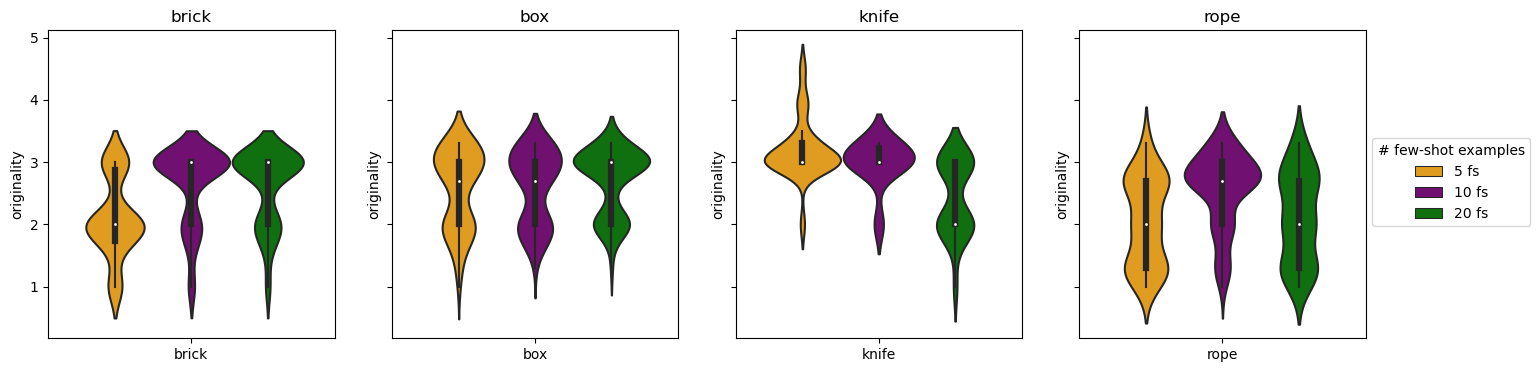

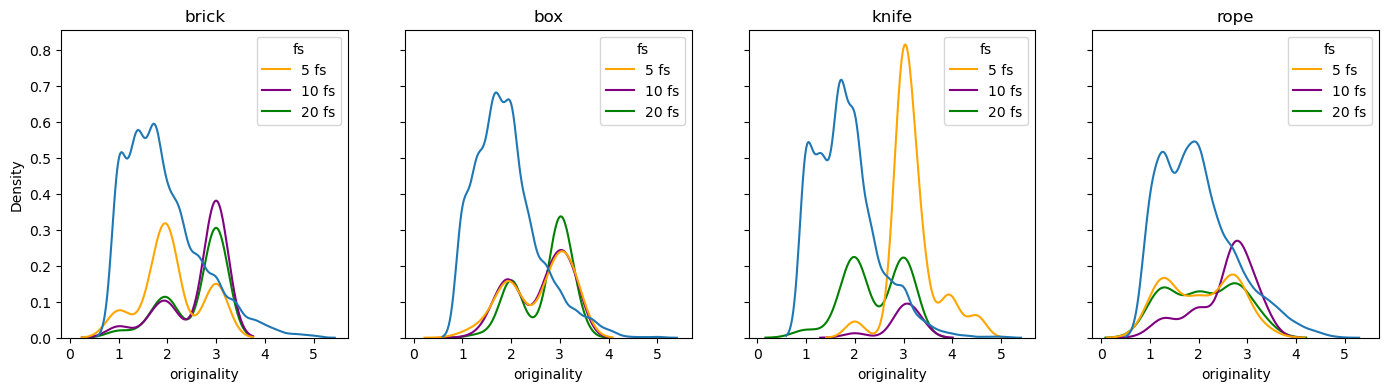

In [64]:
# Define a custom color palette
colors_hue = {'Humans': 'blue', '1 fs': 'red','5 fs': 'orange', '10 fs': 'purple', '20 fs': 'green'}

# violin plots
fig, axs = plt.subplots(1, 4, figsize = (17,4), sharey=True)    

sns.violinplot(x='prompt', y='originality', hue='fs', data=combined_data_brick_exp2, ax=axs[0], palette=colors_hue)
sns.violinplot(x='prompt', y='originality', hue='fs', data=combined_data_box_exp2, ax=axs[1], palette=colors_hue)
sns.violinplot(x='prompt', y='originality', hue='fs', data=combined_data_knife_exp2, ax=axs[2], palette=colors_hue)
sns.violinplot(x='prompt', y='originality', hue='fs', data=combined_data_rope_exp2, ax=axs[3], palette=colors_hue)

for i, object in enumerate(['brick', 'box', 'knife', 'rope']):
    axs[i].set_title(f'{object}')

# Place legend outside the plot to the right
handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.001, 0.5), title='# few-shot examples')
for ax in axs:
    ax.get_legend().remove()
    # remove xlabel
    ax.set_xlabel('')

# kdeplots
fig, axs = plt.subplots(1, 4, figsize = (17,4), sharex=True, sharey=True)

sns.kdeplot(data=combined_data_brick_exp2, x='originality', hue='fs', ax=axs[0], palette=colors_hue)
sns.kdeplot(data=combined_data_box_exp2, x='originality', hue='fs', ax=axs[1], palette=colors_hue)
sns.kdeplot(data=combined_data_knife_exp2, x='originality', hue='fs', ax=axs[2], palette=colors_hue)
sns.kdeplot(data=combined_data_rope_exp2, x='originality', hue='fs', ax=axs[3], palette=colors_hue)

for i, object in enumerate(['brick', 'box', 'knife', 'rope']):
    axs[i].set_title(f'{object}')
    # Humans
    sns.kdeplot(data=ground_truth[ground_truth['prompt'] == object], x='originality', ax=axs[i], label = 'Humans')

plt.show()


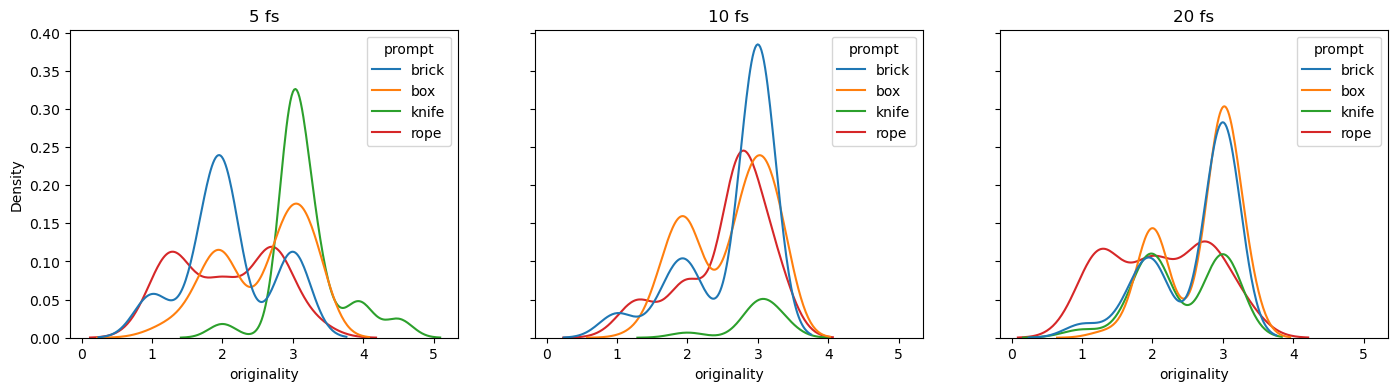

In [47]:
# per object
merged_all = pd.concat([combined_data_brick_exp2, combined_data_box_exp2, combined_data_knife_exp2, combined_data_rope_exp2])

fig, axs = plt.subplots(1, 3, figsize = (17,4), sharex=True, sharey=True)

sns.kdeplot(data=merged_all[merged_all['fs'] == '5 fs'], x='originality', hue='prompt', ax=axs[0])#, palette=colors_hue)
sns.kdeplot(data=merged_all[merged_all['fs'] == '10 fs'], x='originality', hue='prompt', ax=axs[1])#, palette=colors_hue)
sns.kdeplot(data=merged_all[merged_all['fs'] == '20 fs'], x='originality', hue='prompt', ax=axs[2])#, palette=colors_hue)

for i, fs in enumerate(['5 fs', '10 fs', '20 fs']):
    axs[i].set_title(f'{fs}')

plt.show()


## Experiment 3

Contenu du début du prompt
- relaxer contraintes
- mettre le même que dans ground truth = "What is a surprising use for OBJECT?

In [130]:
# test api ocsai
def call_api_ocsai_test(prompt, output_llm):
    base_url = 'https://openscoring.du.edu/llm'
    model = 'ocsai-chatgpt'
    input_value = f"{prompt}, {output_llm}"
    input_type = 'csv'
    elab_method = 'whitespace'
    language = 'English'
    task = 'uses'
    question_in_input = 'false'
    
    # Encode special characters in the input value
    input_value_encoded = input_value.replace(' ', '%20').replace(',', '%2C')
    
    # Construct the URL
    #url = f"{base_url}?model={model}&prompt={prompt}&input={input_value_encoded}&input_type={input_type}&elab_method={elab_method}&language={language}&task={task}&question_in_input={question_in_input}"
    url = f"{base_url}?model={model}&input={input_value_encoded}&input_type={input_type}&elab_method={elab_method}&question_in_input={question_in_input}"
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return None
    
    return response.json()

In [127]:
prompt = 'rope'
output_llm = 'wrap around a bottle for a nautical-themed vase'

In [128]:
eval_ocsai = call_api_ocsai_test(prompt, output_llm)
print(eval_ocsai['scores'][0]['originality'])  # see if we can speed up eval if we pass batches of sentences
print(eval_ocsai['scores'][0]['elaboration'])

https://openscoring.du.edu/llm?model=ocsai-chatgpt&input=rope%2C%20wrap%20around%20a%20bottle%20for%20a%20nautical-themed%20vase&input_type=csv&elab_method=whitespace&question_in_input=false


TypeError: 'int' object is not subscriptable

In [122]:
print('https://openscoring.du.edu/llm?model=ocsai-chatgpt&input=rope%2C%20wrap%20around%20a%20bottle%20for%20a%20nautical-themed%20vase&input_type=csv&elab_method=whitespace&question_in_input=false')

https://openscoring.du.edu/llm?model=ocsai-chatgpt&input=rope%2C%20wrap%20around%20a%20bottle%20for%20a%20nautical-themed%20vase&input_type=csv&elab_method=whitespace&question_in_input=false


In [129]:
df_test = pipeline_object('rope', 30)
# save df_test
df_test.to_csv(f'./data_ocsai/data_exp2/gpt_35/aut_rope_30_test.csv', index=False)

System fingerprint: fp_b28b39ffa8
Prompt tokens: 199
Completion tokens: 509
Total number of tokens: 708
Estimated price: $0.01726


In [131]:
df_test.head()

,prompt,response
0,rope,Create a makeshift clothesline for hanging wet...
1,rope,Use it as a DIY curtain tieback for a rustic t...
2,rope,Fashion it into a stylish belt to add a bohemi...
3,rope,Transform it into a plant hanger to showcase y...
4,rope,Secure outdoor furniture cushions in place on ...


In [132]:
for i in tqdm(range(len(df_test))):
        eval_ocsai = call_api_ocsai_test(df_test.loc[i, 'prompt'], df_test.loc[i, 'response'])
        df_test.loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
        df_test.loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']
df_test.head()

100%|██████████| 29/29 [00:45<00:00,  1.57s/it]


,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,Create a makeshift clothesline for hanging wet...,1.3,8.0
1,rope,Use it as a DIY curtain tieback for a rustic t...,2.0,11.0
2,rope,Fashion it into a stylish belt to add a bohemi...,1.7,14.0
3,rope,Transform it into a plant hanger to showcase y...,3.0,11.0
4,rope,Secure outdoor furniture cushions in place on ...,2.3,9.0
